In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn import metrics

# Preparing dataset

In [2]:
def load_dataset(fname):
    # read dataset
    dataset = pd.read_csv(fname, comment='#')

    # compositions to wt.%
    dataset.C *= 100
    dataset.Mn *= 100
    dataset.Si *= 100
    dataset.Cr *= 100
    dataset.Ni *= 100

    # temperatures to oC
    dataset.A1 -= 273.15
    dataset.A1prime -= 273.15
    dataset.A3 -= 273.15

    return dataset

In [3]:
raw_df = load_dataset('../../databases/Tcritical.csv')
raw_df = raw_df.drop(['file', 'macro'], axis=1)
#raw_df.head()

In [4]:
df = raw_df.copy()

'''
Variables
C, C**2, C*Mn, C*Si, C*Cr, C*Ni, 
Mn, Mn**2, Mn*Si, Mn*Cr, Mn*Ni, 
Si, Si*Si, Si*Cr, Si*Ni, 
Cr, Cr**2, Cr*Ni,
Ni, Ni**2]
'''

df['C2'] = df['C'].apply(lambda x: x**2)
df['CMn'] = df['C'] * df['Mn']
df['CSi'] = df['C'] * df['Si']
df['CCr'] = df['C'] * df['Cr']
df['CNi'] = df['C'] * df['Ni']
df['Mn2'] = df['Mn'].apply(lambda x: x**2)
df['MnSi'] = df['Si'] * df['Mn']
df['MnCr'] = df['Cr'] * df['Mn']
df['MnNi'] = df['Ni'] * df['Mn']
df['Si'] = df['Si'].apply(lambda x: x**2)
df['SiCr'] = df['Cr'] * df['Si']
df['SiNi'] = df['Si'] * df['Ni']
df['Cr2'] = df['Cr'].apply(lambda x: x**2)
df['CrNi'] = df['Cr'] * df['Ni']
df['Ni2'] = df['Ni'].apply(lambda x: x**2)

df.head()

,C,Mn,Si,Cr,Ni,A1,A1prime,A3,eutectoid,C2,...,CNi,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2
0,0.0,0.0001,1.000000e-08,0.0001,0.000100,NaN,NaN,911.65,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-12,1.000000e-12,1.000000e-08,1.000000e-08,1.000000e-08
1,0.0,0.0001,1.000000e-08,0.0001,0.750075,NaN,NaN,880.26,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,7.500750e-05,1.000000e-12,7.500750e-09,1.000000e-08,7.500750e-05,5.626125e-01
2,0.0,0.0001,1.000000e-08,0.0001,1.500050,NaN,NaN,853.25,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,1.500050e-04,1.000000e-12,1.500050e-08,1.000000e-08,1.500050e-04,2.250150e+00
3,0.0,0.0001,1.000000e-08,0.0001,2.250025,NaN,NaN,829.60,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,2.250025e-04,1.000000e-12,2.250025e-08,1.000000e-08,2.250025e-04,5.062613e+00
4,0.0,0.0001,1.000000e-08,0.0001,3.000000,NaN,NaN,808.65,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,3.000000e-04,1.000000e-12,3.000000e-08,1.000000e-08,3.000000e-04,9.000000e+00


# Preparing A1 dataset

In [5]:
df1 = df.copy()
df1 = df.drop(['A3', 'A1prime'], axis=1)
is_na = df1['A1'].isna() 
df1 = df1.loc[~is_na, :] #REMOVE ALL A1 NAN
df1_ = df1.copy()
df1_['eutec'] = (df1_['eutectoid'].map(lambda x: 1 if x == 'hiper' else 0))
df1_ = df1_.drop(['eutectoid'], axis=1) #REMOVE EUTECTOID COLLUMN BECAUSE IT'S A STRING
#df1_

In [6]:
df1_['eutec'].value_counts()

1    3308
0    1151
Name: eutec, dtype: int64

In [7]:
df1_.head()

,C,Mn,Si,Cr,Ni,A1,C2,CMn,CSi,CCr,...,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2,eutec
76,0.0,0.0001,5.062613,0.000100,0.750075,1020.67,0.0,0.0,0.0,0.0,...,1.000000e-08,0.000225,1.000000e-08,7.500750e-05,0.000506,3.797339,1.000000e-08,0.000075,5.626125e-01,0
85,0.0,0.0001,5.062613,1.500050,0.000100,1199.85,0.0,0.0,0.0,0.0,...,1.000000e-08,0.000225,1.500050e-04,1.000000e-08,7.594172,0.000506,2.250150e+00,0.000150,1.000000e-08,0
90,0.0,0.0001,5.062613,2.250025,0.000100,1073.73,0.0,0.0,0.0,0.0,...,1.000000e-08,0.000225,2.250025e-04,1.000000e-08,11.391005,0.000506,5.062613e+00,0.000225,1.000000e-08,0
95,0.0,0.0001,5.062613,3.000000,0.000100,1045.81,0.0,0.0,0.0,0.0,...,1.000000e-08,0.000225,3.000000e-04,1.000000e-08,15.187838,0.000506,9.000000e+00,0.000300,1.000000e-08,0
102,0.0,0.0001,9.000000,0.000100,1.500050,1002.41,0.0,0.0,0.0,0.0,...,1.000000e-08,0.000300,1.000000e-08,1.500050e-04,0.000900,13.500450,1.000000e-08,0.000150,2.250150e+00,0


In [8]:
hiper = df1_['eutec'] == 1
hipo = df1_['eutec'] == 0

df_hiper = df1_.loc[hiper, :]
df_hipo = df1_.loc[hipo, :]

In [9]:
df_hiper.shape

(3308, 21)

In [10]:
df_hipo.shape

(1151, 21)

# A1 Regression

In [11]:
def _split_between_train_and_test(df, size):
    #train size may be 0.8, 0.7 or 0.99
    target = df['A1']
    features = df.iloc[:, :20]
    X_train, X_test, y_train, y_test = train_test_split(
        features,
        target,
        train_size=size,
        random_state=42
    )
    
    X_train = X_train.drop(['A1'], axis=1)
    X_test = X_test.drop(['A1'], axis=1)
    
    print('Train size: {}'.format(X_train.shape))
    print('Test size: {}'.format(X_test.shape))
    return X_train, X_test, y_train, y_test

## Hipereutectoid

In [12]:
X_train, X_test, y_train, y_test = _split_between_train_and_test(df_hiper, 0.8)

Train size: (2646, 19)
Test size: (662, 19)


/home/paula/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
X_train.head()

,C,Mn,Si,Cr,Ni,C2,CMn,CSi,CCr,CNi,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2
5680,1.35,0.000100,2.250150e+00,0.750075,0.000100,1.8225,0.000135,2.025067,1.012601,0.000135,1.000000e-08,0.000150,0.000075,1.000000e-08,1.687781e+00,2.250150e-04,5.626125e-01,0.000075,1.000000e-08
2072,0.45,0.750075,2.250150e+00,3.000000,1.500050,0.2025,0.337534,0.675022,1.350000,0.675022,5.626125e-01,1.125150,2.250225,1.125150e+00,6.750450e+00,3.375338e+00,9.000000e+00,4.500150,2.250150e+00
6516,1.50,1.500050,1.000000e-08,2.250025,0.750075,2.2500,2.250075,0.000150,3.375037,1.125112,2.250150e+00,0.000150,3.375150,1.125150e+00,2.250025e-08,7.500750e-09,5.062613e+00,1.687688,5.626125e-01
6359,1.50,0.000100,9.000000e+00,0.750075,3.000000,2.2500,0.000150,4.500000,1.125112,4.500000,1.000000e-08,0.000300,0.000075,3.000000e-04,6.750675e+00,2.700000e+01,5.626125e-01,2.250225,9.000000e+00
5154,1.20,0.750075,5.626125e-01,0.000100,3.000000,1.4400,0.900090,0.900090,0.000120,3.600000,5.626125e-01,0.562613,0.000075,2.250225e+00,5.626125e-05,1.687838e+00,1.000000e-08,0.000300,9.000000e+00


In [14]:
y_test.head()

2021    712.102
3313    653.475
4270    682.167
3771    729.120
2561    747.180
Name: A1, dtype: float64

In [15]:
y_train.head()

5680    761.210
2072    699.245
6516    690.396
6359    669.785
5154    583.550
Name: A1, dtype: float64

In [16]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
model.intercept_

# predictor = LinearRegression(n_jobs=-1, normalize=True)
# estimator = predictor.fit(X_train, y_train)
# estimator.intercept_

737.2363971593975

In [17]:
list(zip(X_test.keys(), model.coef_))

[('C', -1.9253232252506554),
 ('Mn', -34.148543534848116),
 ('Si', 4.411931179170842),
 ('Cr', 11.171284130875023),
 ('Ni', -4.746348086428423),
 ('C2', -7.395133233882422),
 ('CMn', 20.52106388685329),
 ('CSi', 6.2189215291426745),
 ('CCr', -2.381619209069754),
 ('CNi', 1.03978497532386),
 ('Mn2', -0.3175112629251168),
 ('MnSi', -1.0194518281423595),
 ('MnCr', -2.506956271844109),
 ('MnNi', -15.788797274819304),
 ('SiCr', 0.1364466102572628),
 ('SiNi', -0.4835121752388645),
 ('Cr2', -0.19529238973860963),
 ('CrNi', -2.163105104886979),
 ('Ni2', -10.325248744064416)]

In [72]:
X_test.keys()

Index(['C', 'Mn', 'Si', 'Cr', 'Ni', 'C2', 'CMn', 'CSi', 'CCr', 'CNi', 'Mn2',
       'MnSi', 'MnCr', 'MnNi', 'SiCr', 'SiNi', 'Cr2', 'CrNi', 'Ni2'],
      dtype='object')

In [18]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

### The line / model

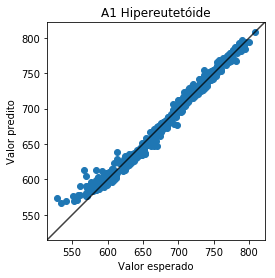

In [19]:
# plt.scatter(y_test, predictions)
# plt.xlabel('True_Values')
# plt.ylabel('Predictions')
# plt.title('A1 Hipereutectoid non-standardized')
# plt.show()

fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r-', alpha=0.75, color='black')
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Valor esperado')
ax.set_ylabel('Valor predito')
ax.set_title('A1 Hipereutetóide')
plt.savefig('img/A1_hiper.png')

In [20]:
metrics.r2_score(y_test, predictions)

0.981703817145134

In [21]:
#MSE
metrics.mean_squared_error(y_test, predictions)

53.68515817322108

In [22]:
#RMSE
math.sqrt(metrics.mean_squared_error(y_test, predictions))

7.327015638936571

## Hipoeutectoid

In [23]:
X_train, X_test, y_train, y_test = _split_between_train_and_test(df_hipo, 0.8)

Train size: (920, 19)
Test size: (231, 19)


In [24]:
X_train.head()

,C,Mn,Si,Cr,Ni,C2,CMn,CSi,CCr,CNi,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2
710,0.15,0.000100,5.062613e+00,1.500050,0.00010,0.0225,0.000015,0.337504,0.225007,0.000015,1.000000e-08,0.000225,0.000150,1.000000e-08,7.594172e+00,5.062613e-04,2.250150,0.00015,1.000000e-08
792,0.15,0.750075,5.626125e-01,2.250025,1.50005,0.0225,0.112511,0.112511,0.337504,0.225007,5.626125e-01,0.562613,1.687688,1.125150e+00,1.265892e+00,8.439469e-01,5.062613,3.37515,2.250150e+00
1472,0.30,0.750075,5.062613e+00,3.000000,1.50005,0.0900,0.225022,0.675007,0.900000,0.450015,5.626125e-01,1.687688,2.250225,1.125150e+00,1.518784e+01,7.594172e+00,9.000000,4.50015,2.250150e+00
1845,0.30,3.000000,5.062613e+00,3.000000,0.00010,0.0900,0.900000,0.675007,0.900000,0.000030,9.000000e+00,6.750075,9.000000,3.000000e-04,1.518784e+01,5.062613e-04,9.000000,0.00030,1.000000e-08
1760,0.30,3.000000,1.000000e-08,1.500050,0.00010,0.0900,0.900000,0.000030,0.450015,0.000030,9.000000e+00,0.000300,4.500150,3.000000e-04,1.500050e-08,1.000000e-12,2.250150,0.00015,1.000000e-08


In [25]:
y_test.head()

800     726.799
1851    635.998
1343    720.779
890     706.682
1621    733.540
Name: A1, dtype: float64

In [26]:
y_train.head()

710     789.420
792     684.522
1472    714.811
1845    688.943
1760    642.493
Name: A1, dtype: float64

In [27]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
model.intercept_

# predictor = LinearRegression(n_jobs=-1, normalize=True)
# estimator = predictor.fit(X_train, y_train)
# estimator.intercept_

848.477364329739

In [28]:
list(zip(X_test.keys(), model.coef_))

[('C', -606.5898106243345),
 ('Mn', -57.66489495611559),
 ('Si', 9.29294110785896),
 ('Cr', 14.346246202965713),
 ('Ni', -31.4061012424471),
 ('C2', 648.5868557743352),
 ('CMn', 101.29548943354851),
 ('CSi', -19.71211866803834),
 ('CCr', 26.11770051057597),
 ('CNi', 59.70142262660468),
 ('Mn2', -2.373870082621206),
 ('MnSi', -0.20546659187693356),
 ('MnCr', -2.0413509410937722),
 ('MnNi', -22.706402721346663),
 ('SiCr', 0.06430759871173741),
 ('SiNi', -0.873923765000824),
 ('Cr2', -3.138609331552571),
 ('CrNi', -0.7556361251713217),
 ('Ni2', -6.77289959747893)]

In [29]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

### The line / model

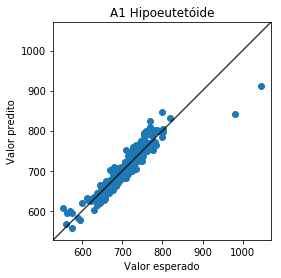

In [30]:
# plt.scatter(y_test, predictions)
# plt.xlabel('True_Values')
# plt.ylabel('Predictions')
# plt.title('A1 Hipoeutectoid non-standardized')
# plt.show()

fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r-', alpha=0.75, color='black')
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Valor esperado')
ax.set_ylabel('Valor predito')
ax.set_title('A1 Hipoeutetóide')
plt.savefig('img/A1_hipo.png')

In [31]:
metrics.r2_score(y_test, predictions)

0.8663182421208461

In [32]:
#MSE
metrics.mean_squared_error(y_test, predictions)

451.3456939609744

In [33]:
#RMSE
math.sqrt(metrics.mean_squared_error(y_test, predictions))

21.244898068971157

## Hipo & Hipereutectoid

In [34]:
X_train, X_test, y_train, y_test = _split_between_train_and_test(df1_, 0.8)

Train size: (3567, 19)
Test size: (892, 19)


In [35]:
X_train.head()

,C,Mn,Si,Cr,Ni,C2,CMn,CSi,CCr,CNi,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2
2572,0.60,0.000100,2.250150e+00,3.000000,1.50005,0.3600,0.000060,0.900030,1.800000,0.900030,1.000000e-08,0.000150,0.000300,1.500050e-04,6.750450e+00,3.375338e+00,9.000000,4.500150,2.250150e+00
4755,1.05,2.250025,1.000000e-08,0.750075,0.00010,1.1025,2.362526,0.000105,0.787579,0.000105,5.062613e+00,0.000225,1.687688,2.250025e-04,7.500750e-09,1.000000e-12,0.562613,0.000075,1.000000e-08
3792,0.90,0.000100,5.626125e-01,2.250025,1.50005,0.8100,0.000090,0.675068,2.025023,1.350045,1.000000e-08,0.000075,0.000225,1.500050e-04,1.265892e+00,8.439469e-01,5.062613,3.375150,2.250150e+00
5244,1.20,0.750075,9.000000e+00,2.250025,3.00000,1.4400,0.900090,3.600000,2.700030,3.600000,5.626125e-01,2.250225,1.687688,2.250225e+00,2.025023e+01,2.700000e+01,5.062613,6.750075,9.000000e+00
4485,1.05,0.000100,9.000000e+00,1.500050,0.00010,1.1025,0.000105,3.150000,1.575052,0.000105,1.000000e-08,0.000300,0.000150,1.000000e-08,1.350045e+01,9.000000e-04,2.250150,0.000150,1.000000e-08


In [36]:
y_test.head()

996     732.870
4032    653.385
4240    748.930
5748    725.530
6215    725.286
Name: A1, dtype: float64

In [37]:
y_train.head()

2572    734.130
4755    695.943
3792    711.925
5244    617.411
4485    803.260
Name: A1, dtype: float64

In [38]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
model.intercept_

# predictor = LinearRegression(n_jobs=-1, normalize=True)
# estimator = predictor.fit(X_train, y_train)
# estimator.intercept_

756.1725974763209

In [39]:
list(zip(X_test.keys(), model.coef_))

[('C', -41.568203855328406),
 ('Mn', -42.53501745043336),
 ('Si', 6.892423764731163),
 ('Cr', 14.903148100007591),
 ('Ni', -11.127676821774275),
 ('C2', 10.240904162625244),
 ('CMn', 28.875761206910347),
 ('CSi', 1.1167326640437079),
 ('CCr', -3.6421148327804644),
 ('CNi', 5.319328336425938),
 ('Mn2', -0.21366073616696202),
 ('MnSi', -1.1921595241491378),
 ('MnCr', -2.7348097417879713),
 ('MnNi', -16.258675199874794),
 ('SiCr', 0.05700121609027686),
 ('SiNi', -0.7351524489780106),
 ('Cr2', -0.6649918174345302),
 ('CrNi', -2.3656463073536766),
 ('Ni2', -9.148254071021029)]

In [40]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

### The line / model

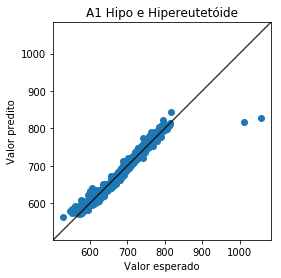

In [41]:
# plt.scatter(y_test, predictions)
# plt.xlabel('True_Values')
# plt.ylabel('Predictions')
# plt.title('A1 Hipo & Hipereutectoid non-standardized')
# plt.show()

fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'r-', alpha=0.75, color='black')
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Valor esperado')
ax.set_ylabel('Valor predito')
ax.set_title('A1 Hipo e Hipereutetóide')
plt.savefig('img/A1_total.png')

In [42]:
metrics.r2_score(y_test, predictions)

0.9424868974593862

In [43]:
#MSE
metrics.mean_squared_error(y_test, predictions)

179.93113103724144

In [44]:
#RMSE
math.sqrt(metrics.mean_squared_error(y_test, predictions))

13.413841024749079

# A1 regression with database standardization

## Hipereutectoid

In [45]:
df2_hiper = df_hiper.copy()
df2_hiper = df2_hiper.loc[~is_na, :]

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df2_hiper.iloc[:, :-1])
df2_hiper.iloc[:, :-1] = scaler.transform(df2_hiper.iloc[:, :-1])

In [47]:
df2_hiper.head()

,C,Mn,Si,Cr,Ni,A1,C2,CMn,CSi,CCr,...,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2,eutec
1273,-2.364845,-1.235560,-1.009829,1.356867,1.085211,0.202458,-1.713275,-1.115688,-1.242873,-0.58338,...,-0.887437,-0.819415,-0.847781,-0.858778,-0.733591,-0.676165,1.621438,2.242533,0.973450,1
1274,-2.364845,-1.235560,-1.009829,1.356867,1.868343,-0.402649,-1.713275,-1.115688,-1.242873,-0.58338,...,-0.887437,-0.819415,-0.847781,-0.858726,-0.733591,-0.676165,1.621438,3.277470,2.403856,1
1299,-2.364845,-1.235560,-0.840272,1.356867,1.868343,-0.279073,-1.713275,-1.115688,-1.066490,-0.58338,...,-0.887437,-0.819383,-0.847781,-0.858726,-0.500140,-0.401453,1.621438,3.277470,2.403856,1
1398,-2.364845,-0.515343,-1.009829,1.356867,1.085211,-1.442724,-1.713275,-0.931366,-1.242873,-0.58338,...,-0.705215,-0.819383,0.104293,0.320837,-0.733591,-0.676165,1.621438,2.242533,0.973450,1
1423,-2.364845,-0.515343,-0.840272,1.356867,1.085211,-1.032155,-1.713275,-0.931366,-1.066490,-0.58338,...,-0.705215,-0.583330,0.104293,0.320837,-0.500140,-0.470129,1.621438,2.242533,0.973450,1


In [48]:
X2_train, X2_test, y2_train, y2_test = _split_between_train_and_test(df2_hiper, 0.8)

Train size: (2646, 19)
Test size: (662, 19)


In [49]:
model2 = lm.fit(X2_train, y2_train)
predictions2 = lm.predict(X2_test)
model2.intercept_

0.0013933294655042484

In [50]:
list(zip(X2_test.keys(), model2.coef_))

[('C', -0.01142804809157441),
 ('Mn', -0.658322269086442),
 ('Si', 0.2710238035519349),
 ('Cr', 0.21694597099769047),
 ('Ni', -0.08415006930373382),
 ('C2', -0.09050605145619073),
 ('CMn', 0.463739931356448),
 ('CSi', 0.14686185633287646),
 ('CCr', -0.054299862694328765),
 ('CNi', 0.0219944340007818),
 ('Mn2', -0.01814888671449976),
 ('MnSi', -0.04497710174593803),
 ('MnCr', -0.10967997556124884),
 ('MnNi', -0.41814399183906414),
 ('SiCr', 0.01826332004394021),
 ('SiNi', -0.05499765279007896),
 ('Cr2', -0.012071598834041894),
 ('CrNi', -0.08705922550217521),
 ('Ni2', -0.5261780321796483)]

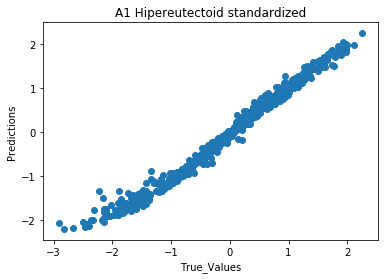

In [51]:
plt.scatter(y2_test, predictions2)
plt.xlabel('True_Values')
plt.ylabel('Predictions')
plt.title('A1 Hipereutectoid standardized')
plt.show()

In [52]:
#R2
metrics.r2_score(y2_test, predictions2)

0.981703817145134

In [53]:
#MSE
metrics.mean_squared_error(y_test, predictions)

179.93113103724144

In [54]:
#RMSE
math.sqrt(metrics.mean_squared_error(y2_test, predictions2))

0.13564703106105064

## Hipoeutectoid

In [55]:
df2_hipo = df_hipo.copy()
df2_hipo = df2_hipo.loc[~is_na, :]

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df2_hipo.iloc[:, :-1])
df2_hipo.iloc[:, :-1] = scaler.transform(df2_hipo.iloc[:, :-1])

In [57]:
df2_hipo.head()

,C,Mn,Si,Cr,Ni,A1,C2,CMn,CSi,CCr,...,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2,eutec
76,-2.087403,-1.050297,0.393366,-1.162274,-0.220213,4.907358,-1.149036,-0.882518,-1.143918,-1.072143,...,-0.737584,-0.766677,-0.652127,-0.701657,-0.686139,0.032155,-0.829527,-0.641949,-0.479079,0
85,-2.087403,-1.050297,0.393366,0.290253,-1.043150,7.679506,-1.149036,-0.882518,-1.143918,-1.072143,...,-0.737584,-0.766677,-0.652044,-0.701743,0.435872,-0.641594,-0.085027,-0.641904,-0.709082,0
90,-2.087403,-1.050297,0.393366,1.016517,-1.043150,5.728266,-1.149036,-0.882518,-1.143918,-1.072143,...,-0.737584,-0.766677,-0.652002,-0.701743,0.996878,-0.641594,0.845524,-0.641860,-0.709082,0
95,-2.087403,-1.050297,0.393366,1.742781,-1.043150,5.296307,-1.149036,-0.882518,-1.143918,-1.072143,...,-0.737584,-0.766677,-0.651961,-0.701743,1.557883,-0.641594,2.148274,-0.641816,-0.709082,0
102,-2.087403,-1.050297,1.554658,-1.162274,0.602725,4.624852,-1.149036,-0.882518,-1.143918,-1.072143,...,-0.737584,-0.766643,-0.652127,-0.701571,-0.686081,1.753975,-0.829527,-0.641904,0.210808,0


In [58]:
X2_train, X2_test, y2_train, y2_test = _split_between_train_and_test(df2_hipo, 0.8)

Train size: (920, 19)
Test size: (231, 19)


In [59]:
model2 = lm.fit(X2_train, y2_train)
predictions2 = lm.predict(X2_test)
model2.intercept_

0.0006258526975433509

In [60]:
list(zip(X2_test.keys(), model2.coef_))

[('C', -1.4184909052969314),
 ('Mn', -0.8767037449200684),
 ('Si', 0.48746865521362753),
 ('Cr', 0.22920158093996626),
 ('Ni', -0.44281368852738445),
 ('C2', 1.0688391355254379),
 ('CMn', 0.580796345907613),
 ('CSi', -0.13464610148925066),
 ('CCr', 0.12105485508033927),
 ('CNi', 0.3144873471027865),
 ('Mn2', -0.10113711750403236),
 ('MnSi', -0.007053233785264109),
 ('MnCr', -0.057117657305753425),
 ('MnNi', -0.3056460685161789),
 ('SiCr', 0.006733540227645505),
 ('SiNi', -0.0761944961532519),
 ('Cr2', -0.14676113341987418),
 ('CrNi', -0.019848073542282768),
 ('Ni2', -0.2563168466904049)]

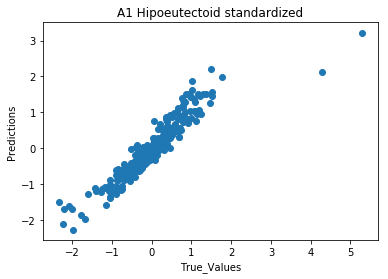

In [61]:
plt.scatter(y2_test, predictions2)
plt.xlabel('True_Values')
plt.ylabel('Predictions')
plt.title('A1 Hipoeutectoid standardized')
plt.show()

In [62]:
#R2
metrics.r2_score(y2_test, predictions2)

0.8663182421208468

In [63]:
#RMSE
math.sqrt(metrics.mean_squared_error(y2_test, predictions2))

0.32868627877390283

## Hipo & Hipereutectoid

In [64]:
df2_ = df1_.copy()
df2_ = df2_.loc[~is_na, :]

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df2_.iloc[:, :-1])
df2_.iloc[:, :-1] = scaler.transform(df2_.iloc[:, :-1])

In [66]:
X2_train, X2_test, y2_train, y2_test = _split_between_train_and_test(df2_, 0.8)

Train size: (3567, 19)
Test size: (892, 19)


In [67]:
model2 = lm.fit(X2_train, y2_train)
predictions2 = lm.predict(X2_test)
model2.intercept_

0.00043088437815732693

In [68]:
list(zip(X2_test.keys(), model2.coef_))

[('C', -0.3135543671923263),
 ('Mn', -0.7644783585751231),
 ('Si', 0.40084433571329303),
 ('Cr', 0.2743797886198435),
 ('Ni', -0.18454210948726038),
 ('C2', 0.1332714308981961),
 ('CMn', 0.5831192096088607),
 ('CSi', 0.02365577943511607),
 ('CCr', -0.07688060417950149),
 ('CNi', 0.10088135460024861),
 ('Mn2', -0.011235038251706728),
 ('MnSi', -0.048649525201467),
 ('MnCr', -0.10768943369091236),
 ('MnNi', -0.37829601535998036),
 ('SiCr', 0.00706389082747748),
 ('SiNi', -0.07705420487865643),
 ('Cr2', -0.03813052282181848),
 ('CrNi', -0.08606344946564498),
 ('Ni2', -0.42865795195154055)]

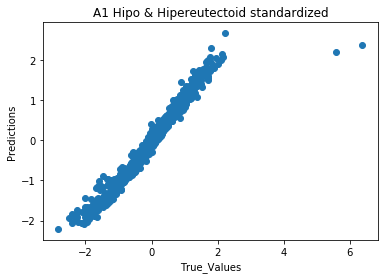

In [69]:
plt.scatter(y2_test, predictions2)
plt.xlabel('True_Values')
plt.ylabel('Predictions')
plt.title('A1 Hipo & Hipereutectoid standardized')
plt.show()

In [70]:
#R2
metrics.r2_score(y2_test, predictions2)

0.9424868974593862

In [71]:
#RMSE
math.sqrt(metrics.mean_squared_error(y2_test, predictions2))

0.233491003585737

# Summarizing...

### Non-standardized

|  | Hipo | Hiper | All |
| --- | --- | --- | --- |
| R2 |0.8663|0.9817|0.9425|
| RMSE |21.2449|7.3270|13.41384|

### Standardized

|  | Hipo | Hiper | All |
| --- | --- | --- | --- |
| R2 |0.8663|0.9817|0.9425|
| RMSE |0.3287|0.1356|0.2335|

### Next steps
- other metrics: relative percentage error